Title: An accelerated generator of pastel canvas
Date: 2018-10-01 14:40
Category: GenerativeArt
Tags: Python
Slug: accelerated-pastel-art-with-python
Cover: /posts/img4000/output_3_0.png
Authors: Peter Schuhmacher
Summary: We try a beautiful art engine and use vectorized forms to accelerate the execution.

We have found in [this inspiring blog post](https://scipython.com/blog/computer-generated-contemporary-art/) a lean engine that generates smart pastel canvas.

The algorithm starts at the left boundary where the first column is initiated with a color that oscillates randomly around a certain value. The algorithm marches now through the canvas to the right. Each pixel within a new column is computed as the mean value of the three nearest neighbouring pixels of the left column - and a certain amount of random noise is added at this step.

The results are images with a lot of atmospheric flair.

# Vectorized code

We have modified the original code and replaced the two outer for-loops by vectorized forms. We use Python's _slice_-forms which allow for a lean writing of the array's indices and still give a fast access to the elements of the array. We have tested that earlier [here](https://stackoverflow.com/questions/45290102/is-2-dimensional-numpy-take-fast/45296732#45296732).

Further we have split the initialisation into a lower and an upper part. So we get a landscape/atmosphere impression.

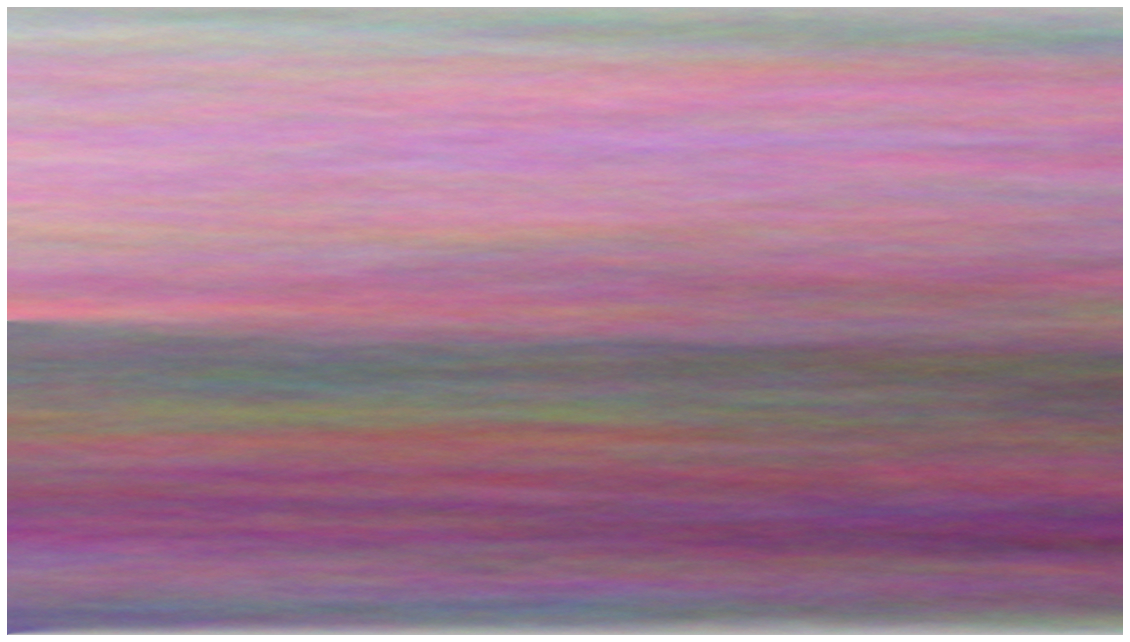

In [1]:
import sys
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.colors as mclr
np.set_printoptions(linewidth=200, precision=3)

def draw_pastell(nx=900, ny=1600, CL=180, rshift=3):
    nz=3
    mid = nx//2
    dCL = 50
    #---- start the coloring ----------
    A = np.ones((nx,ny,nz)) *CL           # initialize the image matrix
    #np.random.seed(1234)                  # initialize RNG
    
    #---- initialize the lower part ----
    ix = slice(0,mid-1);   iz = slice(0,nz)  # color the left boundary
    A[ix,0,iz] =  CL + np.cumsum(np.random.randint(-rshift, rshift+1, size=(mid-1,nz)),axis=0 )
    
    #---- initialize the upper part ----
    ix = slice(mid,nx);   iz = slice(0,nz)  # color the left boundary
    A[ix,0,iz] =  CL-dCL + np.cumsum(np.random.randint(-rshift, rshift+1, size=(nx-mid,nz)),axis=0 )
    
    #---- march to the right boundary -------------
    ix = slice(1,nx-1); ixm = slice(0,nx-2); ixp = slice(2,nx) 
    for jy in range(1,ny):                # smear the color to the right boundary
        A[ix,jy,iz] = 0.3333*(A[ixm,jy-1,iz] + A[ix,jy-1,iz] + A[ixp,jy-1,iz]) + np.random.randint(-rshift, rshift+1, size=(nx-2,nz))
    
    #---- show&save grafics ---------
    im = Image.fromarray(A.astype(np.uint8)).convert('RGBA')
    fig, ax = plt.subplots(figsize=(20,14));
    fileName = 'pic_pastell_B_{}_{}.png'.format(CL,rshift)
    #im.save(fileName)
    plt.axis('off'); plt.imshow(im)


   # nx, ny :   size of image (x,y)
   # CL     :   color level
   # rshift :   spread of random numbers
draw_pastell(nx=900, ny=1600, CL=181, rshift=3)

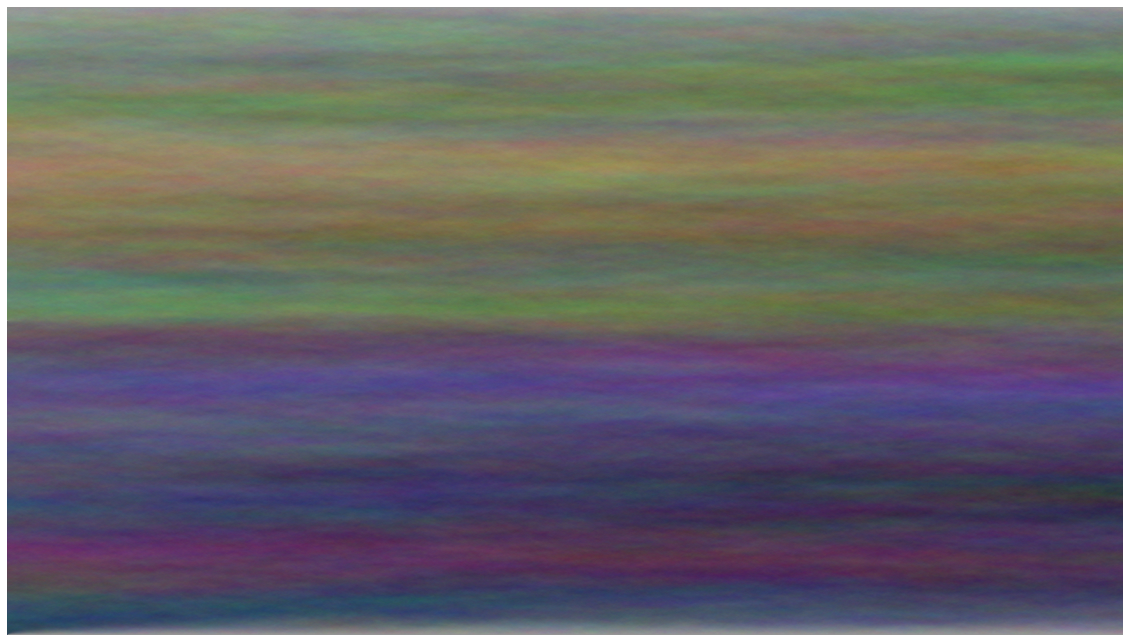

In [2]:
draw_pastell(nx=900, ny=1600, CL=151, rshift=3)

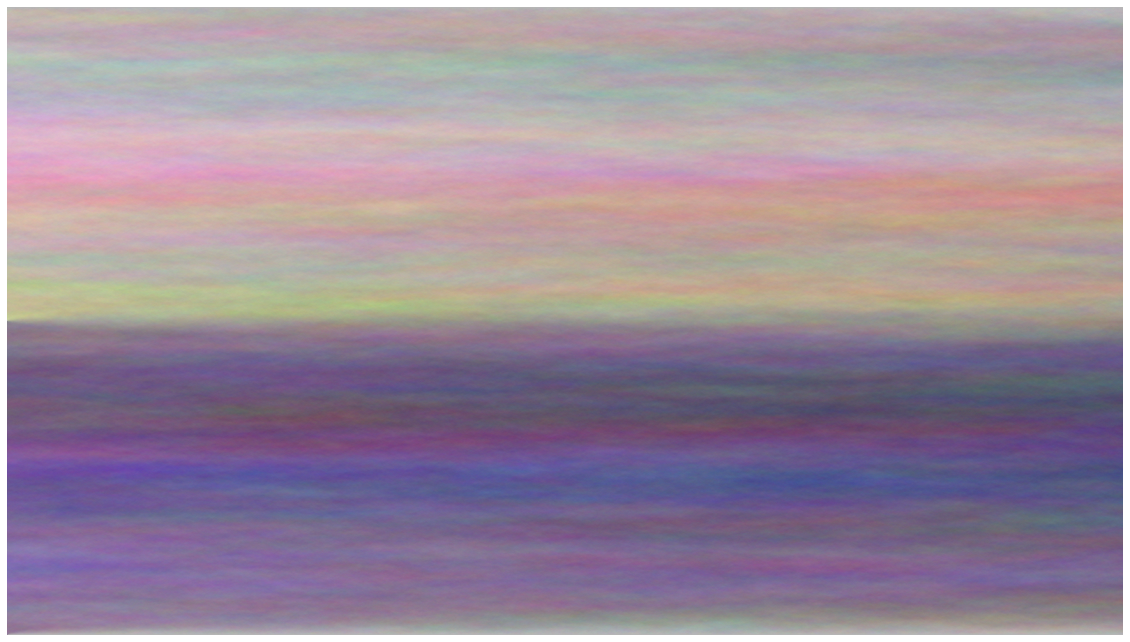

In [3]:
draw_pastell(nx=900, ny=1600, CL=183, rshift=3)

# Code with for-loops

In [4]:
def draw_pastell_FOR(width=1600, height=900, CL=180, rshift=3):
    arr = np.ones((height, width,3)) * CL
    np.random.seed(1234)
    
    for y in range(1,height):
        arr[y,0] = arr[y-1,0] + np.random.randint(-rshift, rshift+1, size=3)

    for x in range(1, width):
        for y in range(1,height-1):
            arr[y,x] = ((arr[y-1, x-1] + arr[y,x-1] + arr[y+1,x-1])/3 ) + np.random.randint(-rshift, rshift+1, size=3)
      
    im = Image.fromarray(arr.astype(np.uint8)).convert('RGBA')
    filename = 'pic_pastell_FOR.png'
    #im.save(filename)
    fig, ax = plt.subplots(figsize=(20,20));
    plt.axis('off'); plt.imshow(im)
    
# draw_pastell_FOR(width=1600, height=900, CL=120, rshift=3)

# Comparing the speed

    %timeit draw_pastell(width=1600, hight=900, CL=180, rshift=3)
    Result:
    1.8 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


    %timeit draw_pastell_FOR(width=1600, hight=900, CL=180, rshift=3)
    Result:
    22.6 s ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
The difference of the runtime is about a **factor 12**.